# Text Classification Assessment

This assessment is a text classification project where the goal is to classify the genre of a movie based on its characteristics, primarily the text of the plot summarization. You have a training set of data that you will use to identify and create your best predicting model. Then you will use that model to predict the classes of the test set of data. We will compare the performance of your predictions to your classmates using the F1 Score. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

The **movie_train.csv** dataset contains information (`Release Year`, `Title`, `Plot`, `Director`, `Cast`) about 10,682 movies and the label of `Genre`. There are 9 different genres in this data set, so this is a multiclass problem. You are expected to primarily use the plot column, but can use the additional columns as you see fit.

After you have identified yoru best performing model, you will create predictions for the test set of data. The test set of data, contains 3,561 movies with all of their information except the `Genre`. 

Below is a list of tasks that you will definitely want to complete for this challenge, but this list is not exhaustive. It does not include any tasds around handling class imbalance or about how to test multiple different models and their tuning parameters, but you should still look at doing those to see if they help you to create a better predictive model.


# Good Luck

### Task #1: Perform imports and load the dataset into a pandas DataFrame

In [2]:
# data processing
import pandas as pd
import numpy as np
import pickle

# pandas DataFrame display options
pd.set_option('display.max_rows', 100)

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-darkgrid')
import itertools

# NLP
import string
import spacy
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from nltk.corpus import stopwords
import string

# Sklearn
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.naive_bayes import MultinomialNB

# Imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler as RUS

# XGBoost
from xgboost import XGBClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/JacquesPierre/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/JacquesPierre/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Functions Needed

In [62]:
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Creating our tokenizer function
def spacy_tokenizer(text):
    # remove html tags from all of the text before processing
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', text)
    # Creating our token object, which is used to create documents with linguistic annotations.
    # we disabled the parser and ner parts of the pipeline in order to speed up parsing
    mytokens = nlp(cleantext, disable=['parser', 'ner'])

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [63]:
# creates the confusion matrix
def plot_confusion_matrix(cm, classes):
    cmap = plt.cm.Blues
    fig = plt.figure(figsize=(10,8));
    ax = fig.add_subplot(111);
    cax = ax.matshow(cm, cmap=cmap);
    fig.colorbar(cax);
    ax.set_xticklabels([''] + classes);
    ax.set_yticklabels([''] + classes);

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), {
            'fontsize' : 18,
            'horizontalalignment' : "center",
            'verticalalignment' : "center"
        }, color="white" if cm[i, j] > thresh else "black")


    plt.xlabel('Predicted');
    plt.ylabel('Actual') ;
    plt.show();

In [64]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

#### import DF

In [65]:
df = pd.read_csv('movie_train.csv', index_col=0)

for col in df.columns:
    formated_col = col.lower()
    df[formated_col] = df[col]
    df.drop(col, axis=1, inplace=True)

print(df.shape)
df.head(15)

(10682, 6)


,release year,title,plot,director,cast,genre
10281,1984,Silent Madness,A computer error leads to the accidental relea...,Simon Nuchtern,"Belinda Montgomery, Viveca Lindfors",horror
7341,1960,Desire in the Dust,"Lonnie Wilson (Ken Scott), the son of a sharec...",Robert L. Lippert,"Raymond Burr, Martha Hyer, Joan Bennett",drama
10587,1986,On the Edge,"A gaunt, bushy-bearded, 44-year-old Wes Holman...",Rob Nilsson,"Bruce Dern, Pam Grier",drama
25495,1988,Ram-Avtar,Ram and Avtar are both childhood best friends....,Sunil Hingorani,"Sunny Deol, Anil Kapoor, Sridevi",drama
16607,2013,Machete Kills,Machete Cortez (Danny Trejo) and Sartana River...,Robert Rodriguez,"Danny Trejo, Michelle Rodriguez, Sofía Vergara...",action
24099,2012,Chupkatha,The film is about an extra-marital affair invo...,Souvick Sarkar and Dipankar,"Payel Roy, Silajit Majumder, Aparajita Auddy, ...",drama
6380,1955,Rage at Dawn,"In this film's version of the story, four of t...",Tim Whelan,"Randolph Scott, Forrest Tucker",western
9322,1976,Welcome to L.A.,The theme of romantic despair and shallowness ...,Alan Rudolph,"Keith Carradine, Geraldine Chaplin, Harvey Keitel",drama
5177,1950,My Blue Heaven,"Kitty Moran (Betty Grable), a radio star, find...",Henry Koster,"Betty Grable, Dan Dailey, Jane Wyatt",comedy
10637,1986,Wildcats,Molly McGrath is the daughter of a famed footb...,Michael Ritchie,"Goldie Hawn, Swoosie Kurtz, Nipsey Russell, Ro...",comedy


### Task #2: Check for missing values:

In [66]:
# Check for NaN values:
df.isnull().sum()

release year      0
title             0
plot              0
director          0
cast            169
genre             0
dtype: int64

### Task #3: Remove NaN values:

In [67]:
df.dropna(inplace=True)

### Task #4: Take a look at the columns and do some EDA to familiarize yourself with the data. 

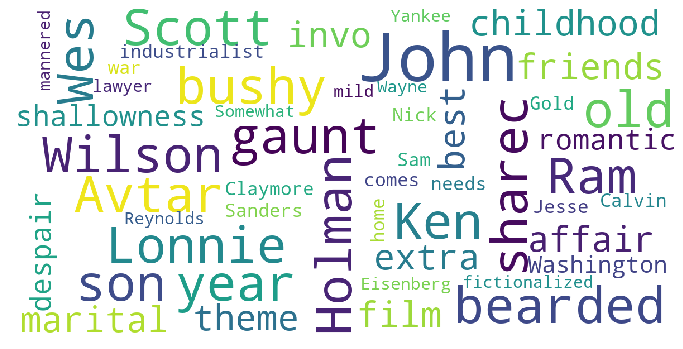

In [70]:
show_wordcloud(df[df['genre']=='drama']['plot'])

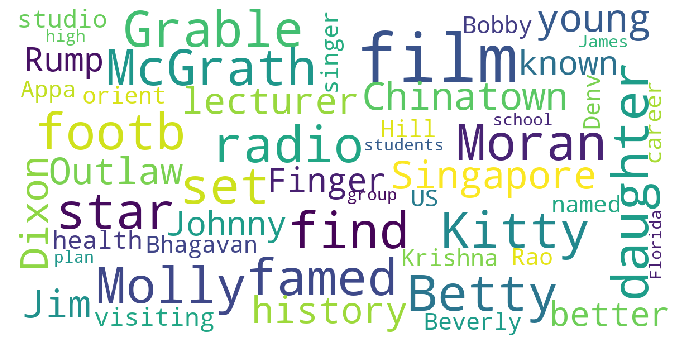

In [71]:
show_wordcloud(df[df['genre']=='comedy']['plot'])

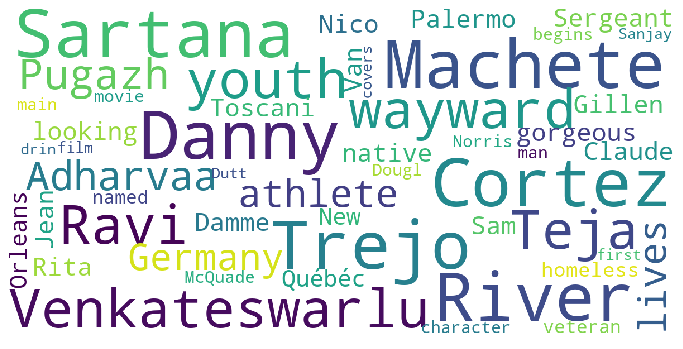

In [72]:
show_wordcloud(df[df['genre']=='action']['plot'])

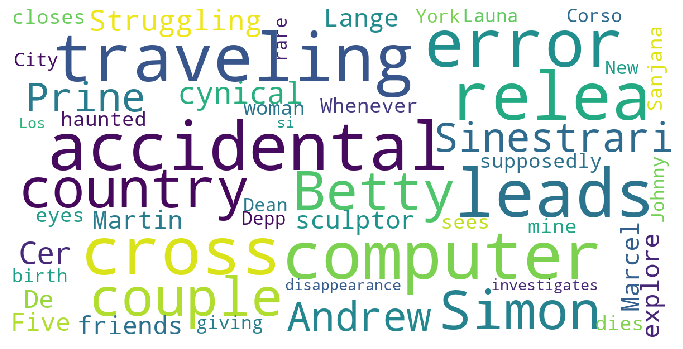

In [74]:
show_wordcloud(df[df['genre']=='horror']['plot'])

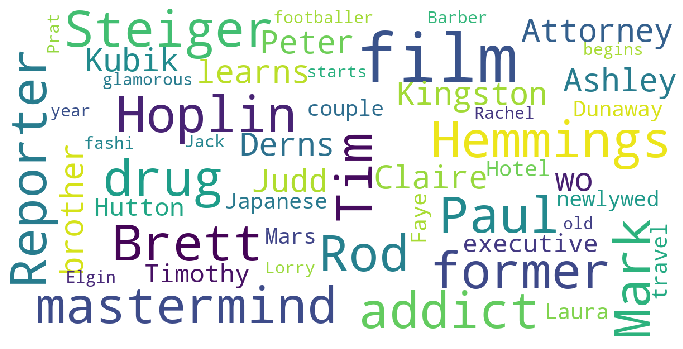

In [75]:
show_wordcloud(df[df['genre']=='thriller']['plot'])

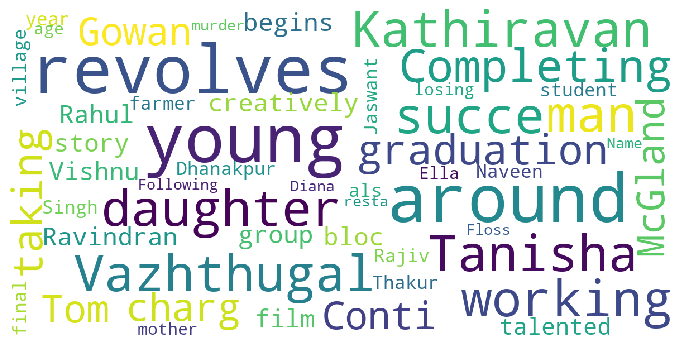

In [76]:
show_wordcloud(df[df['genre']=='romance']['plot'])

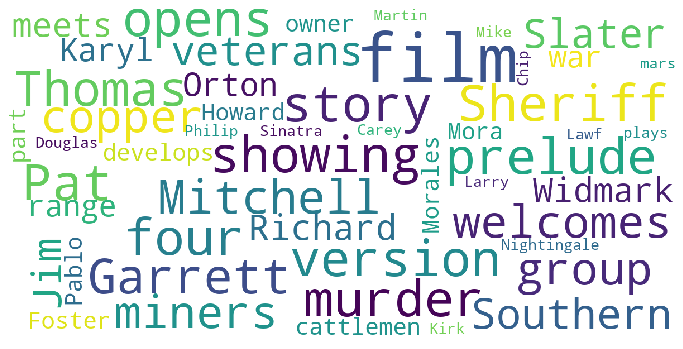

In [77]:
show_wordcloud(df[df['genre']=='western']['plot'])

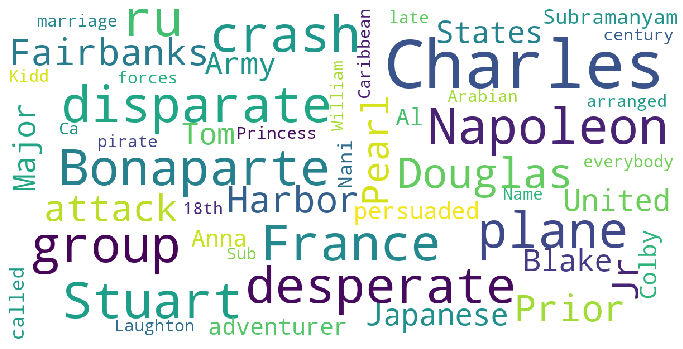

In [78]:
show_wordcloud(df[df['genre']=='adventure']['plot'])

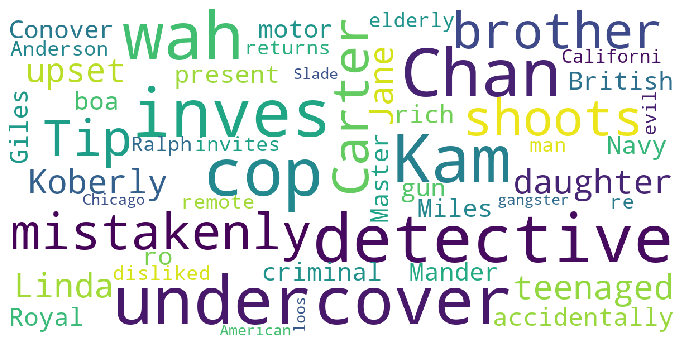

In [79]:
show_wordcloud(df[df['genre']=='crime']['plot'])

In [80]:
df['genre'].value_counts()

drama        3673
comedy       2703
action        823
horror        810
thriller      680
romance       644
western       525
adventure     329
crime         326
Name: genre, dtype: int64

In [81]:
genre = {
    'drama' : 0,
    'comedy' : 1,
    'horror' : 2,
    'action' : 3,
    'thriller' : 4,
    'romance' : 5,
    'western' : 6,
    'adventure' : 7,
    'crime' : 8
}

df['genre'] = df['genre'].replace(genre)
df['genre'].value_counts()

0    3673
1    2703
3     823
2     810
4     680
5     644
6     525
7     329
8     326
Name: genre, dtype: int64

In [82]:
df.head(15)

,release year,title,plot,director,cast,genre
10281,1984,Silent Madness,A computer error leads to the accidental relea...,Simon Nuchtern,"Belinda Montgomery, Viveca Lindfors",2
7341,1960,Desire in the Dust,"Lonnie Wilson (Ken Scott), the son of a sharec...",Robert L. Lippert,"Raymond Burr, Martha Hyer, Joan Bennett",0
10587,1986,On the Edge,"A gaunt, bushy-bearded, 44-year-old Wes Holman...",Rob Nilsson,"Bruce Dern, Pam Grier",0
25495,1988,Ram-Avtar,Ram and Avtar are both childhood best friends....,Sunil Hingorani,"Sunny Deol, Anil Kapoor, Sridevi",0
16607,2013,Machete Kills,Machete Cortez (Danny Trejo) and Sartana River...,Robert Rodriguez,"Danny Trejo, Michelle Rodriguez, Sofía Vergara...",3
24099,2012,Chupkatha,The film is about an extra-marital affair invo...,Souvick Sarkar and Dipankar,"Payel Roy, Silajit Majumder, Aparajita Auddy, ...",0
6380,1955,Rage at Dawn,"In this film's version of the story, four of t...",Tim Whelan,"Randolph Scott, Forrest Tucker",6
9322,1976,Welcome to L.A.,The theme of romantic despair and shallowness ...,Alan Rudolph,"Keith Carradine, Geraldine Chaplin, Harvey Keitel",0
5177,1950,My Blue Heaven,"Kitty Moran (Betty Grable), a radio star, find...",Henry Koster,"Betty Grable, Dan Dailey, Jane Wyatt",1
10637,1986,Wildcats,Molly McGrath is the daughter of a famed footb...,Michael Ritchie,"Goldie Hawn, Swoosie Kurtz, Nipsey Russell, Ro...",1


### Task #5: Split the data into train & test sets:

Yes we have a holdout set of the data, but you do not know the genres of that data, so you can't use it to evaluate your models. Therefore you must create your own training and test sets to evaluate your models. 

In [83]:
SEED = 13

X = df['plot']
y = df['genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

### Task #6: Build a pipeline to vectorize the date, then train and fit your models.
You should train multiple types of models and try different combinations of the tuning parameters for each model to obtain the best one. You can use the SKlearn functions of GridSearchCV and Pipeline to help automate this process.


In [85]:
tfidf = TfidfVectorizer(tokenizer = spacy_tokenizer, sublinear_tf=True, min_df=10, max_df=0.8)

X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

sm = SMOTE(random_state=SEED)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [86]:
X_train.shape

(26253, 10284)

In [87]:
y_train.value_counts()

8    2917
7    2917
6    2917
5    2917
4    2917
3    2917
2    2917
1    2917
0    2917
Name: genre, dtype: int64

### Naive Bayes

In [115]:
# Instantiate classifier and name model
classifier = MultinomialNB()
model_name = "Naive Bayes Model"

# Create param grid for GridSearch
param_grid = {
    'alpha': [0.13]
}

# Create the scorer
scorer = metrics.make_scorer(metrics.f1_score, average = 'weighted')


# Create the grid, with "pipe" as the estimator
nb_clf = GridSearchCV(classifier, param_grid, cv=5, scoring=scorer, verbose=2, n_jobs=-1)

# Fit and make predictions
nb_clf.fit(X_train, y_train)
y_hat_pred = nb_clf.predict(X_train)
y_pred = nb_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
print(nb_clf.best_params_)

# Print F1 score
f1_hat = metrics.f1_score(y_train, y_hat_pred, average = 'weighted')
f1 = metrics.f1_score(y_test, y_pred, average = 'weighted')
print('--'*27)
print(f'{model_name} F1 Scores:')
print('--'*27)
print(f' Train: {f1_hat : 0.2%}')
print(f' Test: {f1 : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names = list(genre.keys())))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


------------------------------------------------------
Naive Bayes Model Best Params:
------------------------------------------------------
{'alpha': 0.13}
------------------------------------------------------
Naive Bayes Model F1 Scores:
------------------------------------------------------
 Train:  91.01%
 Test:  60.17%
------------------------------------------------------
Naive Bayes Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

       drama       0.71      0.54      0.62       756
      comedy       0.65      0.66      0.66       524
      horror       0.66      0.82      0.73       152
      action       0.49      0.54      0.51       151
    thriller       0.38      0.30      0.33       137
     romance       0.36      0.63      0.46       142
     western       0.80      0.91      0.85       121
   adventure       0.51      0.61      0.55        64
       crime       0.34      0.36   

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


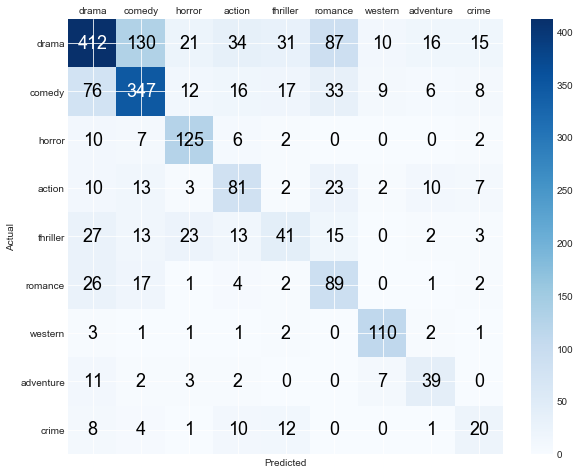

In [107]:
cm = metrics.confusion_matrix(y_test, y_pred)
classes = list(genre.keys())
plot_confusion_matrix(cm, classes)

### Logistic Regression

In [124]:
# Instantiate classifier and name model
classifier = LogisticRegression(penalty = 'l2', random_state = SEED)
model_name = "Logistic Regression Model"

# Create param grid for GridSearch
param_grid = {
    'C' : [1]
}

# Create the scorer
scorer = metrics.make_scorer(metrics.f1_score, average = 'weighted')


# Create the grid, with "pipe" as the estimator
log_clf = GridSearchCV(classifier, param_grid, cv=5, scoring=scorer, verbose=2, n_jobs=-1)

# Fit and make predictions
log_clf.fit(X_train, y_train)
y_hat_pred = log_clf.predict(X_train)
y_pred = log_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
print(log_clf.best_params_)

# Print F1 score
f1_hat = metrics.f1_score(y_train, y_hat_pred, average = 'weighted')
f1 = metrics.f1_score(y_test, y_pred, average = 'weighted')
print('--'*27)
print(f'{model_name} F1 Scores:')
print('--'*27)
print(f' Train: {f1_hat : 0.2%}')
print(f' Test: {f1 : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names = list(genre.keys())))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.3s finished


------------------------------------------------------
Logistic Regression Model Best Params:
------------------------------------------------------
{'C': 1}
------------------------------------------------------
Logistic Regression Model F1 Scores:
------------------------------------------------------
 Train:  95.58%
 Test:  63.79%
------------------------------------------------------
Logistic Regression Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

       drama       0.70      0.63      0.66       756
      comedy       0.68      0.68      0.68       524
      horror       0.74      0.81      0.77       152
      action       0.53      0.58      0.56       151
    thriller       0.39      0.36      0.38       137
     romance       0.47      0.56      0.51       142
     western       0.85      0.88      0.87       121
   adventure       0.54      0.58      0.56        64
       crime       

/Users/JacquesPierre/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


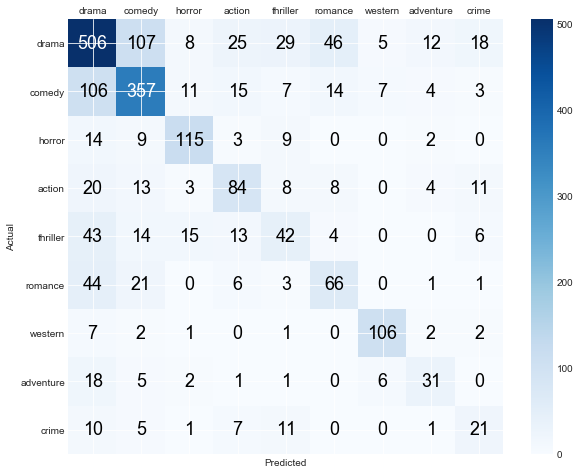

In [123]:
cm = metrics.confusion_matrix(y_test, y_pred)
classes = list(genre.keys())
plot_confusion_matrix(cm, classes)

### Task #7: Run predictions and analyze the results on the test set to identify the best model.  

In [72]:
# Form a prediction set


In [73]:
# Report the confusion matrix



In [74]:
# Print a classification report


In [75]:
# Print the overall accuracy and F1 score


### Task #8: Refit the model to all of your data and then use that model to predict the holdout set. 

In [125]:
X = tfidf.fit_transform(X)

log_clf.fit(X, y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.6s finished
/Users/JacquesPierre/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=13, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1, param_grid={'C': [1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [126]:
unlabeled_X = pd.read_csv('movie_test.csv', index_col=0)
unlabeled_X.drop(['Release Year', 'Title', 'Director', 'Cast'], axis=1, inplace=True)

In [127]:
unlabeled_X

,Plot
5075,After a state senator's bill to abolish chain ...
32149,Irfan Khan (Pavan Malhotra) is a key mafia aff...
7154,The film tells the story of Emma Breslin (O'Su...
4259,The boys are involved in an altercation with a...
7548,Paul Winchell plays a father to Jerry Mahoney ...
...,...
11868,Born in 1930 to a recently widowed Englishwoma...
20101,Professor Alex Bolt has developed a new univer...
23503,"In 1991, Hong Kong police inspector Wong Chi-s..."
8880,"In the early 1920s, Eli (Cliff Robertson) is a..."


In [128]:
unlabeled_X['Plot']

5075     After a state senator's bill to abolish chain ...
32149    Irfan Khan (Pavan Malhotra) is a key mafia aff...
7154     The film tells the story of Emma Breslin (O'Su...
4259     The boys are involved in an altercation with a...
7548     Paul Winchell plays a father to Jerry Mahoney ...
                               ...                        
11868    Born in 1930 to a recently widowed Englishwoma...
20101    Professor Alex Bolt has developed a new univer...
23503    In 1991, Hong Kong police inspector Wong Chi-s...
8880     In the early 1920s, Eli (Cliff Robertson) is a...
31117    The story is narrated through flashbacks. Velu...
Name: Plot, Length: 3561, dtype: object

In [129]:
Z = tfidf.transform(unlabeled_X['Plot'])

In [131]:
y_pred = log_clf.predict(Z)

In [132]:
y_pred

array([0, 3, 0, ..., 3, 0, 4])

In [133]:
unlabeled_X['genre'] = ''
for i in range(0,unlabeled_X.shape[0]):
    unlabeled_X.iloc[i] = y_pred[i]

In [134]:
unlabeled_X.drop('Plot', axis=1, inplace=True)

In [135]:
predictions = unlabeled_X

In [136]:
predictions['genre'].value_counts()

0    1806
1     931
2     279
3     200
6     139
4      81
5      78
7      29
8      18
Name: genre, dtype: int64

In [137]:
genre = {
    0 : 'drama' ,
    1 : 'comedy',
    2 : 'horror',
    3 : 'action',
    4 : 'thriller',
    5 : 'romance',
    6 : 'western',
    7 : 'adventure',
    8 : 'crime'
}

predictions['genre'] = predictions['genre'].replace(genre)
predictions['genre'].value_counts()

drama        1806
comedy        931
horror        279
action        200
western       139
thriller       81
romance        78
adventure      29
crime          18
Name: genre, dtype: int64

In [138]:
predictions.shape

(3561, 1)

In [139]:
predictions.to_csv('finalanswers_jpr.csv', header=False)

### #9: Save your predictions as a csv file that you will send to the instructional staff for evaluation. 

## Great job!